# Exercício Unsupervised Learning
Aluno João Paulo Barbosa

#2 Collaborative Filtering

In [2]:
!pip install scikit-surprise

In [3]:
from surprise import NormalPredictor
from surprise import Dataset
from surprise import Reader
from surprise import SVD
from surprise import SVDpp
from surprise import KNNBasic
from surprise.model_selection import cross_validate

import pandas as pd

In [4]:
df = pd.read_csv("ratings.csv")

In [5]:
df.head()

,userId,jokeId,rating
0,1,5,0.219
1,1,7,-9.281
2,1,8,-9.281
3,1,13,-6.781
4,1,15,0.875


In [6]:
df.tail()

,userId,jokeId,rating
1761434,63978,57,-8.531
1761435,63978,24,-9.062
1761436,63978,124,-9.031
1761437,63978,58,-8.656
1761438,63978,44,-8.438


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1761439 entries, 0 to 1761438
Data columns (total 3 columns):
 #   Column  Dtype  
---  ------  -----  
 0   userId  int64  
 1   jokeId  int64  
 2   rating  float64
dtypes: float64(1), int64(2)
memory usage: 40.3 MB


In [8]:
missing_data = df.isnull().sum()
print (missing_data)


userId    0
jokeId    0
rating    0
dtype: int64


In [9]:
df.nunique()

userId    59132
jokeId      140
rating      641
dtype: int64

Vamos criar o sistema de recomendação utilizando o modelo matrix factorization. Este modelo é mais indicado quando temos um grande volume de dados.

In [10]:
reader = Reader(rating_scale=(-10, 10))

data = Dataset.load_from_df(df[['userId', 'jokeId', 'rating']], reader)

trainSet = data.build_full_trainset()

# Algorithm predicting a random rating based on the distribution of the training set, which is assumed to be normal.
# Estimation based on Maximum Likehood Estimation - not very good
algo = NormalPredictor()

cross_validate(algo, data, measures=['RMSE', 'MAE'], cv=5, verbose=True)

Evaluating RMSE, MAE of algorithm NormalPredictor on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    7.2635  7.2676  7.2603  7.2763  7.2661  7.2668  0.0054  
MAE (testset)     5.8729  5.8795  5.8666  5.8811  5.8752  5.8750  0.0051  
Fit time          5.68    4.40    3.35    4.27    4.13    4.37    0.75    
Test time         12.77   6.36    5.01    6.35    4.71    7.04    2.94    


{'test_rmse': array([7.26354278, 7.2675883 , 7.26032304, 7.27629694, 7.26612072]),
 'test_mae': array([5.8728505 , 5.8795038 , 5.86664729, 5.88108563, 5.87515781]),
 'fit_time': (5.677075624465942,
  4.397686719894409,
  3.352259874343872,
  4.265805006027222,
  4.13254451751709),
 'test_time': (12.771930456161499,
  6.360825777053833,
  5.012942552566528,
  6.35264778137207,
  4.711053371429443)}

É possível perceber métricas de RMSE e MAE muito altas, o que demonstra a fragilidade do algoritmo "Normal Predictor" para esta previsão, por isso vamos testar outro modelo, que será o SVD.

In [11]:
algo = SVD()
# Run 5-fold cross-validation and print results
cross_validate(algo, data, measures=['RMSE', 'MAE'], cv=5, verbose=True)

Evaluating RMSE, MAE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    4.5021  4.4911  4.5017  4.4985  4.4946  4.4976  0.0042  
MAE (testset)     3.3714  3.3668  3.3729  3.3697  3.3695  3.3701  0.0021  
Fit time          29.76   32.21   30.97   36.43   32.06   32.29   2.25    
Test time         5.94    6.51    5.97    8.43    7.06    6.78    0.92    


{'test_rmse': array([4.50207852, 4.49109882, 4.50170104, 4.49852832, 4.49462526]),
 'test_mae': array([3.37139524, 3.36678304, 3.3729313 , 3.36974862, 3.36949112]),
 'fit_time': (29.764880180358887,
  32.205607414245605,
  30.973053216934204,
  36.42975354194641,
  32.064152240753174),
 'test_time': (5.9367616176605225,
  6.5102784633636475,
  5.971647024154663,
  8.430577516555786,
  7.063343524932861)}

Percebemos uma melhora significativa nas métricas de RMSE e MAE, seguiremos com este modelo para realização das análises.

In [12]:
#implementação do anti-testset
testset = trainSet.build_anti_testset()

In [13]:
#criação das previsões
predictions = algo.test(testset)

Vamos agora testar as previsões em três usuários aleatórios.

In [14]:
#ratings do usuário
user = 1

temp_df = df[df['userId'] == user]
temp_df.sort_values(by=['rating'], inplace = True, ascending = False)
temp_df

<ipython-input-14-d25b3a24644f>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp_df.sort_values(by=['rating'], inplace = True, ascending = False)


,userId,jokeId,rating
16,1,50,9.906
15,1,89,9.812
24,1,109,9.656
26,1,93,9.312
27,1,76,9.312
...,...,...,...
6,1,17,-9.031
9,1,20,-9.156
2,1,8,-9.281
1,1,7,-9.281


In [15]:
#Previsões dos ratings das piadas que não haviam sido avaliadas pelo usuário, ordenadas pelo rating em ordem decrescente.
#As piadas com maior rating "est" representam as indicações para este usuário.
pred = pd.DataFrame(predictions)
pred.sort_values(by=['est'], inplace = True, ascending = False)
pred[pred['uid'] == user]

,uid,iid,r_ui,est,details
67,1,140,1.618602,10.000000,{'was_impossible': False}
46,1,111,1.618602,7.906596,{'was_impossible': False}
70,1,143,1.618602,7.159292,{'was_impossible': False}
17,1,47,1.618602,6.951500,{'was_impossible': False}
75,1,148,1.618602,6.576131,{'was_impossible': False}
...,...,...,...,...,...
19,1,46,1.618602,-5.827440,{'was_impossible': False}
10,1,44,1.618602,-7.106176,{'was_impossible': False}
9,1,43,1.618602,-8.072828,{'was_impossible': False}
37,1,57,1.618602,-8.351280,{'was_impossible': False}


Percebe-se que o algoritmo funcionou, e as previsões foram realizadas para o usuário 1, vamos agora verificar com mais dois usuários aleatórios.

In [16]:
user = 10

temp_df = df[df['userId'] == user]
temp_df.sort_values(by=['rating'], inplace = True, ascending = False)
temp_df

<ipython-input-16-61629e352c0e>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp_df.sort_values(by=['rating'], inplace = True, ascending = False)


,userId,jokeId,rating
403,10,32,9.531
409,10,62,9.219
397,10,116,8.781
412,10,66,8.438
389,10,13,8.281
...,...,...,...
391,10,16,-3.844
486,10,24,-5.156
386,10,5,-5.750
415,10,31,-6.188


In [17]:
#Previsões dos ratings das piadas que não haviam sido avaliadas pelo usuário, ordenadas pelo rating em ordem decrescente.
#As piadas "iid" com maior rating "est" representam as indicações para este usuário
pred = pd.DataFrame(predictions)
pred.sort_values(by=['est'], inplace = True, ascending = False)
pred[pred['uid'] == user]

,uid,iid,r_ui,est,details
888,10,122,1.618602,5.750485,{'was_impossible': False}
884,10,114,1.618602,5.105319,{'was_impossible': False}
898,10,139,1.618602,4.792965,{'was_impossible': False}
908,10,149,1.618602,4.785557,{'was_impossible': False}
881,10,111,1.618602,4.503460,{'was_impossible': False}
875,10,121,1.618602,4.425461,{'was_impossible': False}
899,10,140,1.618602,3.939022,{'was_impossible': False}
906,10,147,1.618602,3.855865,{'was_impossible': False}
883,10,113,1.618602,3.817435,{'was_impossible': False}
885,10,126,1.618602,3.658545,{'was_impossible': False}


In [18]:
user = 100

temp_df = df[df['userId'] == user]
temp_df.sort_values(by=['rating'], inplace = True, ascending = False)
temp_df

<ipython-input-18-a138974a41ab>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp_df.sort_values(by=['rating'], inplace = True, ascending = False)


,userId,jokeId,rating
3957,100,7,9.906
3962,100,17,9.594
3959,100,13,8.938
3958,100,8,-0.844
3956,100,5,-0.875
3960,100,15,-0.969
3961,100,16,-9.750


In [19]:
#Previsões dos ratings das piadas que não haviam sido avaliadas pelo usuário, ordenadas pelo rating em ordem decrescente.
#As piadas com maior rating "est" representam as indicações para este usuário
pred = pd.DataFrame(predictions)
pred.sort_values(by=['est'], inplace = True, ascending = False)
pred[pred['uid'] == user]

,uid,iid,r_ui,est,details
8240,100,108,1.618602,6.533741,{'was_impossible': False}
8246,100,72,1.618602,6.055143,{'was_impossible': False}
8261,100,69,1.618602,5.979724,{'was_impossible': False}
8267,100,49,1.618602,5.767856,{'was_impossible': False}
8233,100,50,1.618602,5.749811,{'was_impossible': False}
...,...,...,...,...,...
8283,100,37,1.618602,-1.462629,{'was_impossible': False}
8230,100,24,1.618602,-1.875028,{'was_impossible': False}
8316,100,57,1.618602,-1.961047,{'was_impossible': False}
8347,100,141,1.618602,-3.576866,{'was_impossible': False}


Vamos agora tentar entender correlações entre os usuários e itens a partir das matrizes de fatories latentes, resultantes da modelagem utilizando o algoritmo SVD.

In [27]:
# Obtendo as matrizes de fatores latentes do modelo SVD
user_factors = algo.pu
item_factors = algo.qi

# user_factors e item_factors são matrizes numpy
#user_factors.shape = (num_usuários, num_fatores)
#item_factors.shape = (num_itens, num_fatores)


Vamos tentar visualizar os grupos, utilizando o método PCA de redução de dimensionalidade.

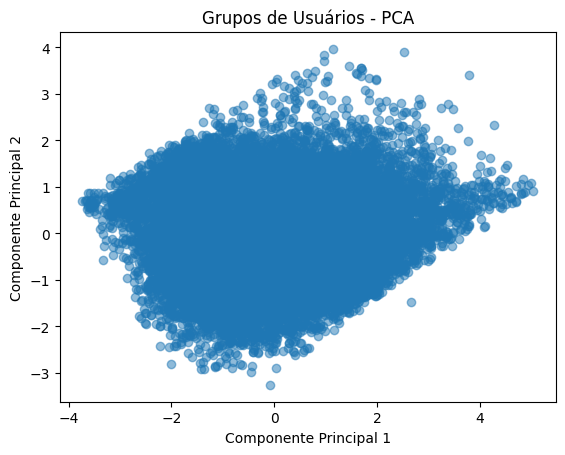

In [25]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Reduzindo a dimensionalidade usando PCA
pca = PCA(n_components=2)
user_factors_2d = pca.fit_transform(user_factors)

# Plot dos grupos no espaço 2D
plt.scatter(user_factors_2d[:, 0], user_factors_2d[:, 1], alpha=0.5)
plt.title('Grupos de Usuários - PCA')
plt.xlabel('Componente Principal 1')
plt.ylabel('Componente Principal 2')
plt.show()

Percebe-se que não houve a separação de grupos bem definidos, existe apenas um grupo principal que não permite a segmentação dos usuários visualmente.

Para tentar identificar similaridades entre os usuários, vamos tentar utilizar um modelo de clustering para entender se existem similaridades entre eles, utilizando o modelo DBSCAN.

In [28]:
# Importar o DBSCAN
from sklearn.cluster import DBSCAN

# Definir o modelo DBSCAN
dbscan = DBSCAN(eps=0.5, min_samples=3)

# Treinar o modelo com os dados
X = df[['userId', 'jokeId', 'rating']]
dbscan.fit(X)

# Obter os rótulos dos clusters para cada ponto de dados
labels_dbscan = dbscan.labels_

# Adicionar os rótulos dos clusters ao DataFrame
df['DBSCAN_Cluster'] = labels_dbscan

# Contagem de clientes em cada cluster do DBSCAN
dbscan_cluster_counts = df['DBSCAN_Cluster'].value_counts()

# Exibir a quantidade de amostras em cada cluster do DBSCAN
print("DBSCAN cluster counts:")
print(dbscan_cluster_counts)

DBSCAN cluster counts:
-1    1761439
Name: DBSCAN_Cluster, dtype: int64


Não foi possível identificar clusters utilizando o método DBSCAN, vamos tentar utilizando método K-means

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


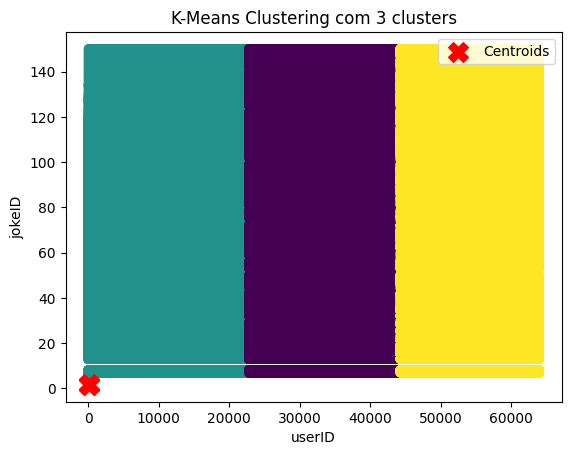

In [ ]:
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

# Definir o número de clusters
k = 3

# Criar o modelo K-Means
kmeans = KMeans(n_clusters=k, random_state=42)

# Treinar o modelo com os dados
kmeans.fit(X)

# Obter os rótulos dos clusters para cada ponto de dados
labels = kmeans.labels_

# Obter as coordenadas dos centros dos clusters
cluster_centers = kmeans.cluster_centers_

# Visualizar os clusters em um scatter plot
plt.scatter(X['userId'], X['jokeId'], c=labels, cmap='viridis')
plt.scatter(cluster_centers[:, 1], cluster_centers[:, 2], s=200, c='red', marker='X', label='Centroids')
plt.xlabel('userID')
plt.ylabel('jokeID')
plt.legend()
plt.title('K-Means Clustering com 3 clusters')
plt.show()


#Conclusão:
Criamos o modelo de previsão baseado no algoritmo SVD, o mesmo apresentou métricas de RMSE e MAE razoáveis e aceitáveis. O modelo se mostrou capaz de realizar as previsões, conforme demonstrado com três usuários. Infelizmente não foi possível identificar relações entre os usuários por meio da visualização da matriz de fatores latentes e dos modelos de clustering, portanto não é possível dizer com certeza se as indicações realizadas pelo modelo são realmente adequadas aos usuários, ou se os perfis e preferências dos usuários aleatoriamente são diferentes entre si.